In [1]:
%load_ext autoreload
%autoreload 2

import os
import numpy as np
import pandas as pd
from matplotlib import cm
from tqdm import tqdm
import json
import anndata as ad

import matplotlib.pyplot as plt
import seaborn as sns

import scanpy as sc
import squidpy as sq
from scipy.spatial import KDTree
import networkx as nx


from src.slide_utilities import *

import warnings
warnings.filterwarnings('ignore')

In [5]:
threshol_set = {
    'X2'  : {'threshold' : [75, 800], 'remove_no' : []},
    'X4'  : {'threshold' : [20, 800], 'remove_no' : [6]},
    'X12'  : {'threshold' : [80, 800], 'remove_no' : []},
    'X13'  : {'threshold' : [80, 800], 'remove_no' : [10, 27, 26, 22, 24, 17, 18, 20, 15]},
    'X14'  : {'threshold' : [12, 800], 'remove_no' : [12]},
    'X15'  : {'threshold' : [120, 800], 'remove_no' : []},
    'X16'  : {'threshold' : [120, 800], 'remove_no' : []},
    'X17'  : {'threshold' : [50, 800], 'remove_no' : [41, 49, 31]},
    'X21'  : {'threshold' : [100, 8000], 'remove_no' : [5,28,24,62,65,76,119,133,135,139,173,176,177,93,101,116,115,106,171,168,169,87,22,170,48,54,95,11,18,17,178,137,142,11,130,97,11,84,78,83,131,26,30,61,82,114,11,18,17]},
    'X23'  : {'threshold' : [20, 800], 'remove_no' : [0, 4, 5]},
    'X24'  : {'threshold' : [100, 800], 'remove_no' : []},
    'X25'  : {'threshold' : [0, 800], 'remove_no' : [0, 3, 6, 7, 8, 10]},
    'X27'  : {'threshold' : [100, 800], 'remove_no' : []},
    'X29'  : {'threshold' : [100, 800], 'remove_no' : []},
    'X30'  : {'threshold' : [100, 800], 'remove_no' : []},
    'X33'  : {'threshold' : [100, 800], 'remove_no' : []},
    'X35'  : {'threshold' : [80, 800], 'remove_no' : [9]},
    'X36'  : {'threshold' : [80, 800], 'remove_no' : [12, 7, 25, 24]},
    'X37'  : {'threshold' : [20, 800], 'remove_no' : [9,10,11,19,7]},
    'X38'  : {'threshold' : [20, 800], 'remove_no' : [5, 13]},
    'X39'  : {'threshold' : [80, 800], 'remove_no' : []},
    'X40'  : {'threshold' : [20, 800], 'remove_no' : [2]},
    'X43'  : {'threshold' : [20, 800], 'remove_no' : [0,2,12]},
    'X45'  : {'threshold' : [20, 800], 'remove_no' : [0,5]},
    'X46'  : {'threshold' : [150, 800], 'remove_no' : [3, 5]},
    'X47'  : {'threshold' : [50, 800], 'remove_no' : []},
    'X48'  : {'threshold' : [100, 800], 'remove_no' : []},
    'X49'  : {'threshold' : [100, 800], 'remove_no' : []},
    'X50'  : {'threshold' : [50, 800], 'remove_no' : []},
    'X51'  : {'threshold' : [20, 800], 'remove_no' : [1, 12]},
    'X52'  : {'threshold' : [20, 800], 'remove_no' : [5},
    'X53'  : {'threshold' : [50, 900], 'remove_no' : [21,27,26,33,35,36,16,55,61,63,64,65,62]},
    'X53'  : {'threshold' : [50, 900], 'remove_no' : []},
    'X54'  : {'threshold' : [20, 900], 'remove_no' : [9]},
    'X56'  : {'threshold' : [100, 900], 'remove_no' : [0]},
    'X58'  : {'threshold' : [100, 900], 'remove_no' : []},
    'X60'  : {'threshold' : [50, 900], 'remove_no' : [0, 2, 3, 13, 16]},
    'X62'  : {'threshold' : [200, 900], 'remove_no' : []},
    'X63'  : {'threshold' : [200, 900], 'remove_no' : []},
}

In [2]:
adata = sc.read_h5ad("data/adata_nichepca_per_sample_with_domain_2.h5ad")
adata = ad.AnnData(
    X=adata.X, 
    obs=adata.obs,
    uns={'spatial': adata.uns['spatial']},
    obsm={'spatial': adata.obsm['spatial']}
)
adata

AnnData object with n_obs × n_vars = 3222037 × 480
    obs: 'x', 'y', 'z', 'cluster', 'n_transcripts', 'density', 'elongation', 'area', 'avg_confidence', 'avg_assignment_confidence', 'max_cluster_frac', 'lifespan', 'x_centroid', 'y_centroid', 'cell_area', 'Slide_ID', 'batch', 'Patient_Sample_ID', 'Disease', 'n_genes', 'celltype_l1', 'celltype_l1_codes', 'celltype_l1_prob', 'Biopsy_ID', 'sample', 'per_sample_leiden_res_0.03', 'per_sample_leiden_res_0.05', 'per_sample_leiden_res_0.07', 'per_sample_leiden_res_0.09', 'per_sample_leiden_res_0.11', 'per_sample_leiden_res_0.13', 'per_sample_leiden_res_0.15', 'per_sample_leiden_res_0.17', 'per_sample_leiden_res_0.19', 'per_sample_leiden_res_0.21', 'per_sample_leiden_res_0.23', 'per_sample_leiden_res_0.25', 'per_sample_leiden_res_0.27', 'per_sample_leiden_res_0.29', 'per_sample_leiden_res_0.31', 'per_sample_leiden_res_0.33', 'per_sample_leiden_res_0.35', 'per_sample_leiden_res_0.37', 'per_sample_leiden_res_0.39', 'domains'
    uns: 'spatial'
  

In [3]:
sample_set = adata.obs['sample'].unique()
# list(sample_set)

In [16]:
## Get glom locations
# i = 0
# sample = sample_set[i]
sample = 'X1'

adata_i = adata[adata.obs['sample'] == sample]
df_glom_i = adata_i.obs.loc[adata_i.obs['domains'] == 'Glom.', ['x', 'y']]

df_glom_i.head()

,x,y
cell_CR4f0dee9aa-189785,9251.568464,16996.043010
cell_CR4f0dee9aa-189832,9258.245880,16992.951174
cell_CR4f0dee9aa-189874,9266.057111,16989.577000
cell_CR4f0dee9aa-189972,9271.752209,17003.666612
cell_CR4f0dee9aa-189991,9287.594175,16983.899025


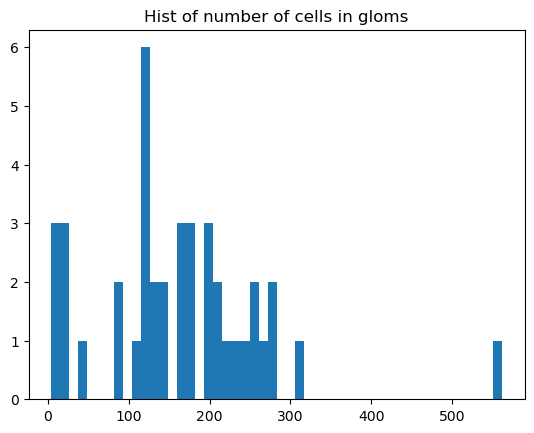

Text(0.5, 1.0, 'Isolated samples')

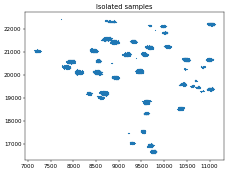

In [17]:
# Cluster gloms
## Make a distnace matrix via KDTree
coords = np.array(df_glom_i)
kdtree = KDTree(coords)
dist_mat = kdtree.sparse_distance_matrix(kdtree, max_distance=50)

## Convert into a "networkx" object
edge_index = np.array(dist_mat.nonzero())
G = nx.Graph()
G.add_edges_from(edge_index.T)

## Get connected components
cc = list(nx.connected_components(G))

## Plot hist for number of cells in gloms
sizes = np.array([len(c) for c in cc])
plt.hist(sizes, 50);
plt.title("Hist of number of cells in gloms")
plt.show()

# plot
dpi = 40
plt.figure(dpi=dpi)
plt.scatter(coords[:, 0], coords[:, 1], s=1, cmap="jet")
plt.title("Isolated samples")

In [7]:
# Set threshold
threshold = [50, 800]
remove_no = []

# threshold = [0, 8000]
# remove_no = []

cc_filtered = [c for i, c in enumerate(cc) if (len(c) > threshold[0]) and (len(c) < threshold[1]) and (i not in remove_no)]

if len(cc_filtered) == 0:
    print('No glom remained')
else:
    print(f'Number of glomes remained = {len(cc_filtered)}')
    ## set glom numbers
    filtered_nodes = np.hstack([list(c) for c in cc_filtered])
    glom_number = []
    for i in filtered_nodes:
        for n, c in enumerate(cc_filtered):
            i_in_c = list(c).count(i) > 0
            if i_in_c:
                glom_number.append(n)
                break

Number of glomes remained = 13


In [8]:
# Make glom_adata "adata_glom" for sample i
X_glom = adata_i.X[adata_i.obs['domains'] == 'Glom.', :].copy()
adata_glom = sc.AnnData(X_glom)
adata_glom.var = adata_i.var
adata_glom.obs = adata_i.obs.loc[adata_i.obs['domains'] == 'Glom.', 
                              ['x', 'y', 'n_transcripts', 'domains']]
# adata_glom.obs['sample'] = sample.split("_")[0]
# adata_glom.obs['label'] = sample.split("_")[1]
adata_glom = adata_glom[filtered_nodes,:]
adata_glom.obs['domain_tuned'] = 'Glom.'
adata_glom.obs['glom_no'] = glom_number

In [9]:
# Add to the adata
## restrict adata to adata_i
adata_i = adata[adata.obs['sample'] == sample].copy()
df_i = adata_glom.obs.copy()

## Merge df_gnn_i to adata_i.obs
merged_df = adata_i.obs.merge(df_i[['domain_tuned', 'glom_no']], 
                              left_index=True, 
                              right_index=True,
                              how='left', 
                              suffixes=('', '_nichepca'))
adata_i.obs.shape, merged_df.shape

((56620, 45), (56620, 47))

In [10]:
adata_i.obs = merged_df
adata_i.obs.head()

,x,y,z,cluster,n_transcripts,density,elongation,area,avg_confidence,avg_assignment_confidence,...,per_sample_leiden_res_0.27,per_sample_leiden_res_0.29,per_sample_leiden_res_0.31,per_sample_leiden_res_0.33,per_sample_leiden_res_0.35,per_sample_leiden_res_0.37,per_sample_leiden_res_0.39,domains,domain_tuned,glom_no
cell_CR53cd53b06-227888,1850.914963,15904.448037,20.608806,1,67,2.182,1.509,30.70,0.9978,0.9946,...,2,2,2,3,2,3,2,Other,NaN,NaN
cell_CR53cd53b06-228933,2361.172066,15460.200987,19.548733,1,38,1.673,1.122,22.72,0.9965,0.9932,...,0,0,0,0,1,0,0,Prox. Tubule,NaN,NaN
cell_CR53cd53b06-229666,1848.324100,16016.575525,22.140017,4,101,1.789,3.005,56.45,0.9978,0.9152,...,2,2,2,3,2,3,2,Other,NaN,NaN
cell_CR53cd53b06-229685,1841.556380,16021.983300,22.037009,3,140,2.627,2.444,53.29,0.9978,0.9117,...,2,2,2,3,2,3,2,Other,NaN,NaN
cell_CR53cd53b06-229765,1856.330364,16012.196442,22.963489,3,182,1.937,1.706,93.96,0.9969,0.8924,...,2,2,2,3,2,3,2,Other,NaN,NaN


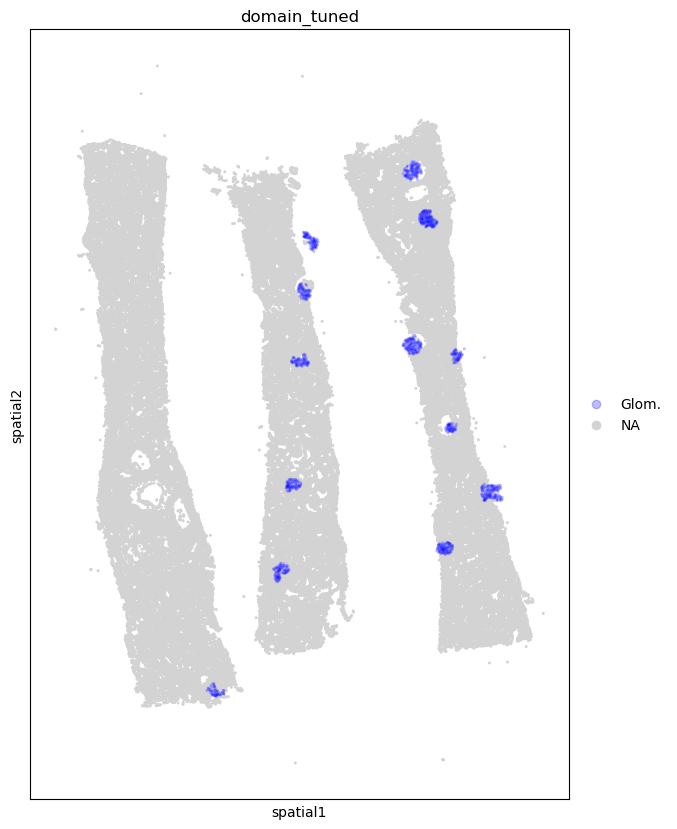

In [11]:
# Plot
plot_HE = False
show = True
slide = adata_i.obs['Slide_ID'][0]

## add color
colormap = {'Glom.': '#0000FF40'}
adata_i.obs['domain_tuned'] = pd.Categorical(adata_i.obs['domain_tuned'], 
                                       categories=list(colormap.keys()), 
                                       ordered=True)
adata_i.uns['domain_tuned_colors'] = list(colormap.values())

fig, ax = plt.subplots(figsize=(10, 10))
sc.pl.spatial(adata_i,
              library_id=slide,
              img_key='he_downscaled_aligned' if plot_HE else None,
              color='domain_tuned',
              size=0.5,
              ax=ax,
              show=show
             )

if show:
    plt.show()
else:
    plt.savefig(f"figure_gloms/sample_{sample.split('_')[0]}.pdf", bbox_inches='tight')
plt.close(fig)

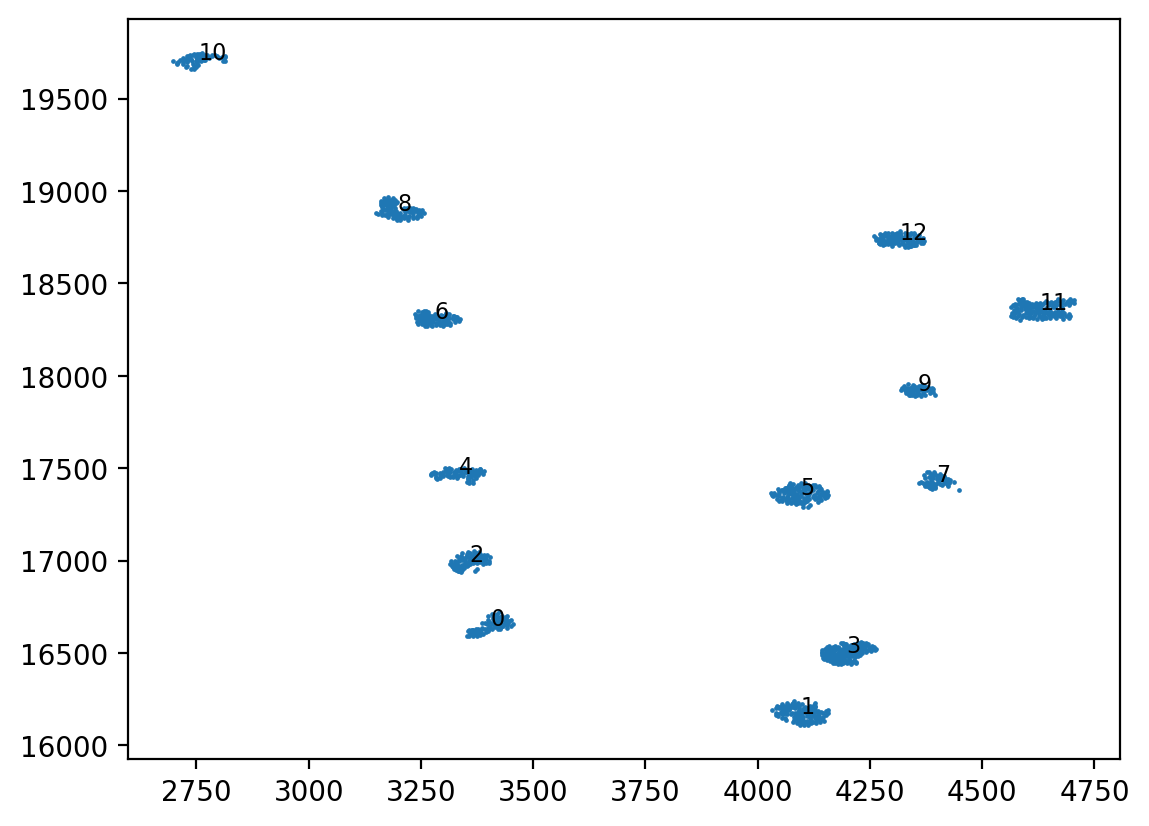

In [12]:
dpi = 200
plt.figure(dpi=dpi)
glom_mask = adata_i.obs['domain_tuned'] == 'Glom.'
plt.scatter(adata_i.obs.loc[glom_mask, 'x'], adata_i.obs.loc[glom_mask, 'y'], s=.5)

for i in range(len(cc_filtered)):
    centroid = adata_i.obs.loc[adata_i.obs['glom_no'] == i, ['x', 'y']].mean()
    plt.text(centroid[0], centroid[1], f"{i}", fontsize=8)

In [13]:
print(ax.get_xlim())
print(ax.get_ylim())
sample

(1492.1347205128204, 5161.75358034188)
(20446.875638157897, 15212.264098684203)


'X26'

In [14]:
adata_i.obs.to_csv(f"obs/data_tuned_glom_{sample.split('_')[0]}.csv")
f"obs/data_tuned_glom_{sample.split('_')[0]}.h5ad"

'obs/data_tuned_glom_X26.h5ad'

In [15]:
# Plot
plot_HE = False
show = False
slide = adata_i.obs['Slide_ID'][0]

## add color
colormap = {'Glom.': '#0000FF40'}
adata_i.obs['domain_tuned'] = pd.Categorical(adata_i.obs['domain_tuned'], 
                                       categories=list(colormap.keys()), 
                                       ordered=True)
adata_i.uns['domain_tuned_colors'] = list(colormap.values())

fig, ax = plt.subplots(figsize=(10, 10))
sc.pl.spatial(adata_i,
              library_id=slide,
              img_key='he_downscaled_aligned' if plot_HE else None,
              color='domain_tuned',
              size=0.5,
              ax=ax,
              show=show
             )

if show:
    plt.show()
else:
    plt.savefig(f"figure_gloms/sample_{sample.split('_')[0]}.pdf", bbox_inches='tight')
plt.close(fig)

In [42]:
# GNN-based annotation benefits
# time
# human eror
# HE image registration missmatch
# accurate boundries

## All in a loop

In [2]:
# Read data: registered with harmony embedding
adata = sc.read_h5ad("data/adata_nichepca_per_sample_with_domain_2.h5ad")
adata = ad.AnnData(
    X=adata.X, 
    obs=adata.obs,
    uns={'spatial': adata.uns['spatial']},
    obsm={'spatial': adata.obsm['spatial']}
)
sample_set = adata.obs['Patient_Sample_ID'].unique()
sample_set

['X40_SLE', 'X39_SLE', 'X38_GBM', 'X37_ANCA', 'X36_ANCA', ..., 'X21_GBM', 'X20_ANCA', 'X19_ANCA', 'X18_ANCA', 'X17_ANCA']
Length: 63
Categories (63, object): ['X1_Cntrl', 'X2_Cntrl', 'X3_ANCA', 'X4_ANCA', ..., 'X60_ANCA', 'X61_SLE', 'X62_SLE', 'X63_ANCA']

In [4]:
threshold = [20, 800]

for i, sample in enumerate(sample_set):
    print(f"{sample}_{i}")

    adata_i = adata[adata.obs['Patient_Sample_ID'] == sample]
    df_glom_i = adata_i.obs.loc[adata_i.obs['domains'] == 'Glom.', ['x', 'y']]

    # Cluster gloms
    ## Make a distnace matrix via KDTree
    coords = np.array(df_glom_i)
    kdtree = KDTree(coords)
    dist_mat = kdtree.sparse_distance_matrix(kdtree, max_distance=50)

    ## Convert into a "networkx" object
    edge_index = np.array(dist_mat.nonzero())
    G = nx.Graph()
    G.add_edges_from(edge_index.T)

    ## Get connected components
    cc = list(nx.connected_components(G))

    # Filter gloms
    remove_no = []
    cc_filtered = [c for i, c in enumerate(cc) if (len(c) > threshold[0]) and (len(c) < threshold[1]) and (i not in remove_no)]

    if len(cc_filtered) == 0:
        print('No glom remained')
        continue
    ## set glom numbers
    filtered_nodes = np.hstack([list(c) for c in cc_filtered])
    glom_number = []
    for i in filtered_nodes:
        for n, c in enumerate(cc_filtered):
            i_in_c = list(c).count(i) > 0
            if i_in_c:
                glom_number.append(n)
                break

    # Make glom_adata "adata_glom" for sample i
    X_glom = adata_i.X[adata_i.obs['domains'] == 'Glom.', :].copy()
    adata_glom = sc.AnnData(X_glom)
    adata_glom.var = adata_i.var
    adata_glom.obs = adata_i.obs.loc[adata_i.obs['domains'] == 'Glom.', 
                                  ['x', 'y', 'n_transcripts', 'domains']]
    adata_glom.obs['sample'] = sample.split("_")[0]
    adata_glom.obs['label'] = sample.split("_")[1]
    adata_glom = adata_glom[filtered_nodes,:]
    adata_glom.obs['domain_tuned'] = 'Glom.'
    adata_glom.obs['glom_no'] = glom_number

    # Add to the adata
    ## restrict adata to adata_i
    adata_i = adata[adata.obs['Patient_Sample_ID'] == sample].copy()
    df_i = adata_glom.obs.copy()

    ## Merge df_gnn_i to adata_i.obs
    merged_df = adata_i.obs.merge(df_i[['domain_tuned', 'glom_no']], 
                                  left_index=True, 
                                  right_index=True,
                                  how='left', 
                                  suffixes=('', '_nichepca'))

    adata_i.obs = merged_df

    # Save adata
    adata_i.obs.to_csv(f"obs/data_tuned_glom_{sample.split('_')[0]}.csv")

    # Plot
    plot_HE = False
    show = False
    slide = adata_i.obs['Slide_ID'][0]
    
    ## add color
    colormap = {'Glom.': '#0000FF40'}
    adata_i.obs['domain_tuned'] = pd.Categorical(adata_i.obs['domain_tuned'], 
                                           categories=list(colormap.keys()), 
                                           ordered=True)
    adata_i.uns['domain_tuned_colors'] = list(colormap.values())
    
    fig, ax = plt.subplots(figsize=(10, 10))
    sc.pl.spatial(adata_i,
                  library_id=slide,
                  img_key='he_downscaled_aligned' if plot_HE else None,
                  color='domain_tuned',
                  size=0.5,
                  ax=ax,
                  show=show
                 )
    
    if show:
        plt.show()
    else:
        plt.savefig(f"figure_gloms/sample_{sample.split('_')[0]}.pdf", bbox_inches='tight')
    plt.close(fig)

X40_SLE_0
X39_SLE_1
X38_GBM_2
X37_ANCA_3
X36_ANCA_4
X35_ANCA_5
X34_ANCA_6
X33_ANCA_7
X63_ANCA_8
X61_SLE_9
X62_SLE_10
X60_ANCA_11
X59_ANCA_12
No glom remained
X58_ANCA_13
X57_Cntrl_14
X32_SLE_15
X31_SLE_16
X30_SLE_17
X29_GBM_18
X28_ANCA_19
X27_ANCA_20
X26_ANCA_21
No glom remained
X25_ANCA_22
X56_SLE_23
X55_SLE_24
X54_SLE_25
X53_ANCA_26
X52_ANCA_27
X50_ANCA_28
X51_ANCA_29
X49_ANCA_30
X8_SLE_31
X7_SLE_32
X6_ANCA_33
X4_ANCA_34
X5_GBM_35
No glom remained
X2_Cntrl_36
X3_ANCA_37
X1_Cntrl_38
X48_SLE_39
X47_SLE_40
X46_GBM_41
X45_ANCA_42
X44_ANCA_43
X43_ANCA_44
X42_ANCA_45
No glom remained
X41_Cntrl_46
X16_SLE_47
X15_SLE_48
X14_ANCA_49
X12_ANCA_50
X13_GBM_51
X11_ANCA_52
No glom remained
X10_Cntrl_53
X9_Cntrl_54
X24_SLE_55
X23_SLE_56
X22_SLE_57
X21_GBM_58
X20_ANCA_59
X19_ANCA_60
X18_ANCA_61
X17_ANCA_62


In [18]:
# Merge all adata_i into adata

## Read data: registered with harmony embedding
adata = sc.read_h5ad("/data/projects/robin/segmentation/xenium_outs/merged_processed_cleaned.h5ad")

sample_set = adata.obs['Patient_Sample_ID'].unique()
sample_set

['X40_SLE', 'X39_SLE', 'X38_GBM', 'X37_ANCA', 'X36_ANCA', ..., 'X21_GBM', 'X20_ANCA', 'X19_ANCA', 'X18_ANCA', 'X17_ANCA']
Length: 63
Categories (63, object): ['X1_Cntrl', 'X2_Cntrl', 'X3_ANCA', 'X4_ANCA', ..., 'X60_ANCA', 'X61_SLE', 'X62_SLE', 'X63_ANCA']

In [19]:
# Add empty cols to adata
adata.obs['sample'] = 'na'
adata.obs['label'] = 'na'
adata.obs['nichepca_domain'] = 'na'
adata.obs['nichepca_domain_tuned'] = float('nan')
adata.obs['nichepca_glom_no'] = float('nan')

In [20]:
f"obs/data_tuned_glom_{sample.split('_')[0]}.csv"

'obs/data_tuned_glom_X1.csv'

In [21]:
for sample in tqdm(sample_set):

    adata.obs.loc[adata.obs['Patient_Sample_ID'] == sample, 'sample'] = sample.split("_")[0]
    adata.obs.loc[adata.obs['Patient_Sample_ID'] == sample, 'label'] = sample.split("_")[1]

    obs_path = f"obs/data_tuned_glom_{sample.split('_')[0]}.csv"
    if os.path.exists(obs_path):
        # read NichePCA annotation result
        adata_i_obs = pd.read_csv(obs_path, index_col=0)
    
        adata.obs.loc[adata_i_obs.index, 'nichepca_domain'] = adata_i_obs['domains']
        adata.obs.loc[adata_i_obs.index, 'nichepca_domain_tuned'] = adata_i_obs['domain_tuned']
        adata.obs.loc[adata_i_obs.index, 'nichepca_glom_no'] = adata_i_obs['glom_no']
    else:
        print("pass")
        pass

 19%|█▉        | 12/63 [00:05<00:22,  2.31it/s]

pass


 56%|█████▌    | 35/63 [00:15<00:09,  2.97it/s]

pass


 71%|███████▏  | 45/63 [00:19<00:09,  1.99it/s]

pass


 83%|████████▎ | 52/63 [00:22<00:05,  2.00it/s]

pass


100%|██████████| 63/63 [00:30<00:00,  2.09it/s]


In [22]:
(adata.obs['nichepca_domain_tuned'] == 'Glom.').sum()

169938

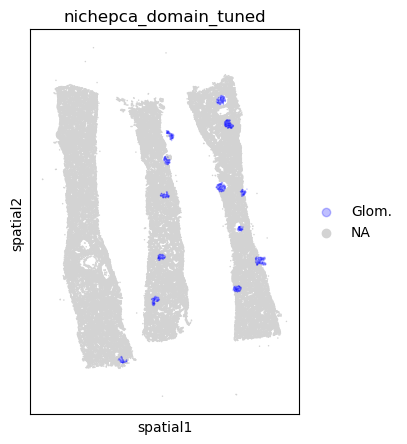

In [24]:
# # Final check plot
plot_HE = False

sample = 26
adata_i = adata[adata.obs['sample'] == f'X{sample}'].copy()
slide = adata_i.obs['Slide_ID'][0]


## add color
colormap = {'Glom.': '#0000FF40'}#, 'Other': '#1100040'}
adata_i.obs['nichepca_domain_tuned'] = pd.Categorical(adata_i.obs['nichepca_domain_tuned'], 
                                       categories=list(colormap.keys()), 
                                       ordered=True)
adata_i.uns['nichepca_domain_tuned_colors'] = list(colormap.values())

fig, ax = plt.subplots(figsize=(5, 5))
sc.pl.spatial(adata_i,
              library_id=slide,
              img_key='he_downscaled_aligned' if plot_HE else None,
              color='nichepca_domain_tuned',
              size=0.5,
              ax=ax)
plt.show()

In [16]:
# adata.write("adata/adata_nichepca_all_with_domain_tuned_v0.h5ad")

In [25]:
adata.obs['nichepca_domain_tuned'] = adata.obs['nichepca_domain_tuned'].astype('category')
adata.obs['nichepca_domain_tuned'] = adata.obs['nichepca_domain_tuned'].cat.add_categories('Other')
adata.obs['nichepca_domain_tuned'] = adata.obs['nichepca_domain_tuned'].fillna('Other')

adata.obs['nichepca_glom_no'] = adata.obs['nichepca_glom_no'].astype('category')
adata.obs['nichepca_glom_no'] = adata.obs['nichepca_glom_no'].cat.add_categories('Other')
adata.obs['nichepca_glom_no'] = adata.obs['nichepca_glom_no'].fillna('Other')
adata.obs['nichepca_glom_no'] = [int(i) if i!= 'Other' else 'Other' for i in adata.obs['nichepca_glom_no']]
adata.obs['nichepca_glom_no'] = adata.obs['nichepca_glom_no'].astype(str).astype('category')
adata.obs['nichepca_domain_tuned'], adata.obs['nichepca_glom_no']

(cell_CRfb095a77d-1         Other
 cell_CRfb095a77d-2         Other
 cell_CRfb095a77d-3         Other
 cell_CRfb095a77d-5         Other
 cell_CRfb095a77d-6         Other
                            ...  
 cell_CRc71d71060-597925    Other
 cell_CRc71d71060-598041    Other
 cell_CRc71d71060-598270    Other
 cell_CRc71d71060-598508    Other
 cell_CRc71d71060-598872    Other
 Name: nichepca_domain_tuned, Length: 3222037, dtype: category
 Categories (2, object): ['Glom.', 'Other'],
 cell_CRfb095a77d-1         Other
 cell_CRfb095a77d-2         Other
 cell_CRfb095a77d-3         Other
 cell_CRfb095a77d-5         Other
 cell_CRfb095a77d-6         Other
                            ...  
 cell_CRc71d71060-597925    Other
 cell_CRc71d71060-598041    Other
 cell_CRc71d71060-598270    Other
 cell_CRc71d71060-598508    Other
 cell_CRc71d71060-598872    Other
 Name: nichepca_glom_no, Length: 3222037, dtype: category
 Categories (73, object): ['0', '1', '10', '11', ..., '71', '8', '9', 'Other'])

In [26]:
adata.obs

,x,y,z,cluster,n_transcripts,density,elongation,area,avg_confidence,avg_assignment_confidence,...,n_genes,celltype_l1,celltype_l1_codes,celltype_l1_prob,Biopsy_ID,sample,label,nichepca_domain,nichepca_domain_tuned,nichepca_glom_no
cell_CRfb095a77d-1,2285.790178,1164.057381,32.829188,1,79,2.0240,2.141,39.03,0.9975,0.9916,...,55,MAC,8,0.999994,0011695 - X1,X40,SLE,Prox. Tubule,Other,Other
cell_CRfb095a77d-2,2298.342622,1219.741069,31.465535,4,32,1.0850,4.614,29.50,0.9771,0.9288,...,17,PT,16,1.000000,0011695 - X1,X40,SLE,Prox. Tubule,Other,Other
cell_CRfb095a77d-3,2271.434052,1245.859500,32.062796,2,67,3.0590,2.990,21.90,0.9971,0.9884,...,44,FIB,6,1.000000,0011695 - X1,X40,SLE,DistaL Con. Tubule,Other,Other
cell_CRfb095a77d-5,2257.346907,1259.955827,31.273945,2,56,2.1420,9.229,26.14,0.9964,0.9707,...,40,FIB,6,0.999103,0011695 - X1,X40,SLE,DistaL Con. Tubule,Other,Other
cell_CRfb095a77d-6,2277.712022,1237.595244,35.395148,2,9,1.6980,3.283,5.30,0.9826,0.9400,...,7,DTL,4,0.582253,0011695 - X1,X40,SLE,DistaL Con. Tubule,Other,Other
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
cell_CRc71d71060-597925,2747.360264,4957.516627,24.097605,2,73,1.5480,3.617,47.15,0.9971,0.6334,...,10,MAC,8,1.000000,0011216 - X2,X24,SLE,Other,Other,Other
cell_CRc71d71060-598041,4592.548620,1655.438877,24.254944,2,35,0.9893,1.844,35.38,0.9951,0.6206,...,6,MAC,8,1.000000,0011216 - X3,X24,SLE,Other,Other,Other
cell_CRc71d71060-598270,8540.113826,9224.561804,19.515240,3,46,1.3870,2.667,33.16,0.9969,0.7152,...,8,FIB,6,1.000000,0011216 - X9,X21,GBM,Other,Other,Other
cell_CRc71d71060-598508,4264.902000,2582.697217,25.121288,3,24,1.1420,5.004,21.02,0.9914,0.7517,...,6,VSM/P,20,0.998473,0011216 - X3,X24,SLE,Other,Other,Other


In [27]:
adata.write_h5ad("adata/adata_nichepca_with_domain_tuned_per_sample_v3.h5ad")